In [1]:
import re
import requests

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-paper')

import seaborn as sb
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd

from itertools import chain
from collections import Counter

In [2]:
file = "https://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/Facebook_Economy.csv"

In [3]:
fb_economy = pd.read_csv(file,index_col='IDLink')

In [4]:
fb_economy.tail()

,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,TS10,...,TS135,TS136,TS137,TS138,TS139,TS140,TS141,TS142,TS143,TS144
IDLink,,,,,,,,,,,,,,,,,,,,,
58440,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
58441,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
58444,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
58446,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,2,2,2,2,2,2,2,2,2,2
58447,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [5]:
top_10 = fb_economy.TS144.nlargest(10).index

**Investigating the lifespan of the ten most popular stories by TS144**

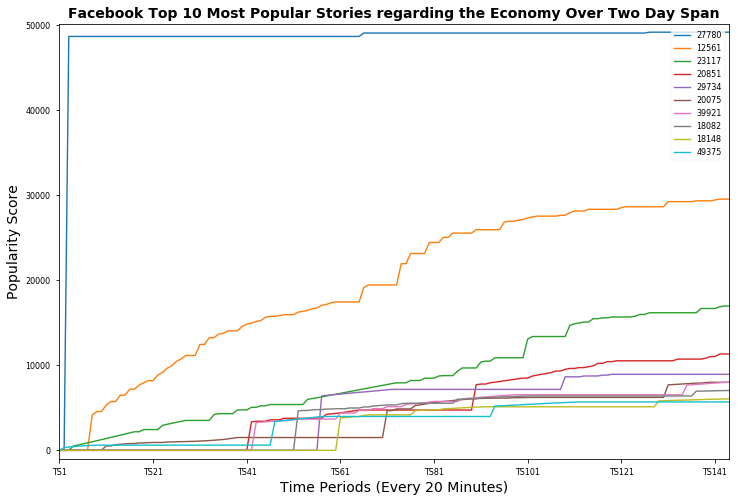

In [6]:
fb_economy.loc[top_10].T.plot(figsize=(12,8))
plt.legend(loc='upper right')
plt.title('Facebook Top 10 Most Popular Stories regarding the Economy Over Two Day Span',fontsize=14,fontweight='bold')
plt.xlabel('Time Periods (Every 20 Minutes)',fontsize=14)
plt.ylabel('Popularity Score',fontsize=14)
plt.margins(0.02)
plt.show()

**Using the chain method to collect the periodic top ten stories and unpack the list of lists into a single list of dicts**

In [7]:
top_10_periodically = list(chain.from_iterable([list(fb_economy[k].nlargest(10).index) for k in list(fb_economy.columns)]))

In [8]:
top_10_periodically[:10]

[47982, 46935, 45397, 2229, 7389, 43233, 43985, 48003, 51600, 2279]

**Converting dicts into tuples to make it easier for DataFrame construction using .from_records(data) method**

In [9]:
count_top_10_appearances = [(k, v) for k, v in dict(Counter(top_10_periodically)).items()]

In [10]:
count_top_10_appearances[:10]

[(47982, 25),
 (46935, 12),
 (45397, 5),
 (2229, 2),
 (7389, 2),
 (43233, 1),
 (43985, 1),
 (48003, 1),
 (51600, 1),
 (2279, 1)]

In [11]:
trending_df = pd.DataFrame.from_records(count_top_10_appearances,columns=['ID','Count']).set_index('ID')

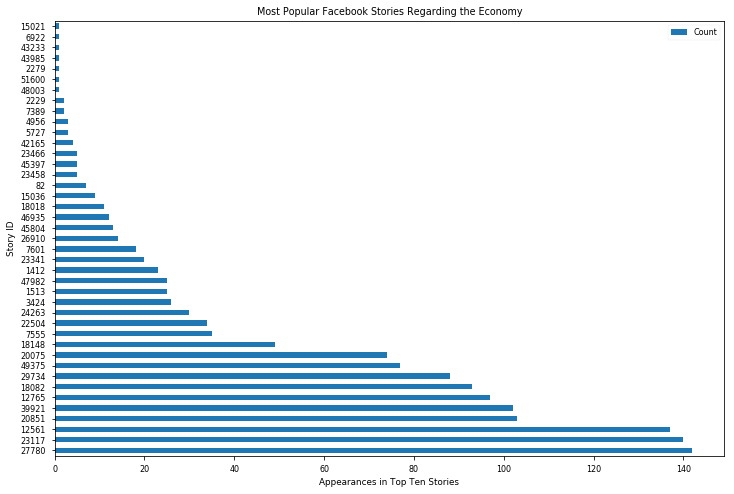

In [12]:
fig = trending_df.sort_values(by='Count',ascending=False).plot(kind='barh',figsize=(12,8))
plt.title('Most Popular Facebook Stories Regarding the Economy')
plt.ylabel('Story ID')
plt.xlabel('Appearances in Top Ten Stories')
plt.show()

In [51]:
fb_economy.loc[27780].max()

49211

### Creating Delayed Objects from .csv files to speed things up

In [14]:
pattern = r'[F|L|G]\w+_\w+'

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/'
u = requests.get(url)

In [15]:
url_find = sorted(list(set(re.findall(pattern,u.text))))

In [16]:
url_find

['Facebook_Economy',
 'Facebook_Microsoft',
 'Facebook_Obama',
 'Facebook_Palestine',
 'GooglePlus_Economy',
 'GooglePlus_Microsoft',
 'GooglePlus_Obama',
 'GooglePlus_Palestine',
 'LinkedIn_Economy',
 'LinkedIn_Microsoft',
 'LinkedIn_Obama',
 'LinkedIn_Palestine']

In [17]:
def df_read(file,url=url):
    full_path = url+file+'.csv'
    platform, topic = file.split('_')
    df = pd.read_csv(full_path,index_col='IDLink')
    df.index = df.index.astype('int64').astype('object')
    df['Platform'] = platform
    df['Topic'] = topic
    df['Platform_Topic']= file
    return df

In [18]:
delayed = (dask.delayed(df_read)(u) for u in url_find)

In [19]:
delayed_df = dd.from_delayed(delayed)
delayed_df = delayed_df.persist()

In [20]:
platform_group = delayed_df.drop(['Platform','Topic'],axis=1).groupby('Platform_Topic')

In [21]:
platform_group.mean().head()

,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,TS10,...,TS135,TS136,TS137,TS138,TS139,TS140,TS141,TS142,TS143,TS144
Platform_Topic,,,,,,,,,,,,,,,,,,,,,
Facebook_Economy,-0.420710,0.019814,2.061080,2.586240,2.994988,3.285251,3.813085,4.345295,4.701751,5.244219,...,44.256750,44.341687,44.512597,44.618818,44.717221,44.804431,44.888466,45.117482,45.233995,45.335739
Facebook_Microsoft,-0.404349,0.050888,0.482867,1.030813,1.376073,1.671847,2.145972,2.444390,2.673574,3.135772,...,36.434623,36.501160,36.614646,36.713237,36.783606,36.843344,36.950785,36.988614,37.045599,37.081863
Facebook_Obama,2.773903,4.434833,6.643272,11.199371,13.373422,15.518157,19.446863,22.260448,24.857264,29.556061,...,287.680474,288.310642,288.945919,289.585304,290.350694,291.055673,294.480955,296.397594,298.233056,299.485212
Facebook_Palestine,-0.177442,0.148432,0.516977,2.323663,2.673735,3.123715,3.651359,4.105373,4.566671,5.092754,...,53.027579,53.192923,53.334721,53.448419,53.729804,53.875244,54.380513,54.653311,55.038116,55.248471
GooglePlus_Economy,-0.640419,-0.497687,-0.396867,-0.244700,-0.221265,-0.201397,-0.112069,-0.093471,-0.075690,-0.012912,...,1.709214,1.713962,1.719768,1.725211,1.729656,1.733104,1.737065,1.743143,1.746742,1.751247


Text(0.5,0,'Time Periods (Every 20 Minutes)')

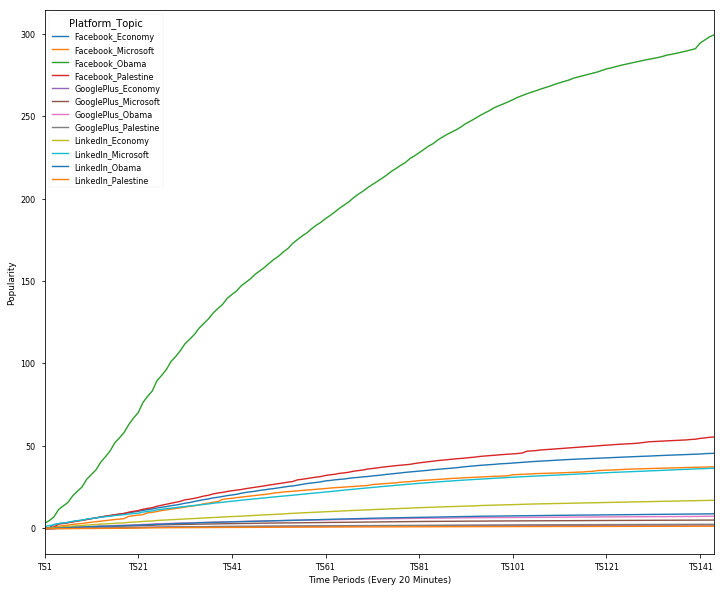

In [22]:
platform_group.mean().compute().T.plot(figsize=(12,10))
plt.ylabel('Popularity')
plt.xlabel('Time Periods (Every 20 Minutes)')

### Unsurprisingly, Facebook articles on Obama drew the most attention.

In [23]:
#for some reason, it is not letting me perform .nlargest() on the SeriesGroupBy object - Dask issue?
#Instead, I am using .apply() with a lambda nlargest function

top_10_by_platform_topic = pd.DataFrame(platform_group.TS144.apply(lambda x: x.nlargest(10)).compute())

C:\Users\mgavin\Anaconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.


In [35]:
top_10_df = pd.melt(top_10_by_platform_topic.reset_index(),id_vars=['IDLink','Platform_Topic'],value_vars=['TS144'],value_name='Popularity after 2 Days')
top_10_df.drop('variable',axis=1,inplace=True)

In [37]:
top_10_df.set_index('IDLink',drop=True,inplace=True)

In [38]:
top_10_df.index = top_10_df.index.astype('object')
top_10_df.index.dtype

dtype('O')

In [39]:
top_10_df.head(20)

,Platform_Topic,Popularity after 2 Days
IDLink,,
72143,Facebook_Obama,40836
76901,Facebook_Obama,32385
72045,Facebook_Obama,30489
62638,Facebook_Obama,24594
67508,Facebook_Obama,22518
65424,Facebook_Obama,19136
67141,Facebook_Obama,17170
90713,Facebook_Obama,16598
94081,Facebook_Obama,15692


In [40]:
top_articles_platform_topic = list(top_10_df.index)

In [41]:
top_articles_platform_topic

[72143,
 76901,
 72045,
 62638,
 67508,
 65424,
 67141,
 90713,
 94081,
 90631,
 23117,
 2070,
 12561,
 7555,
 29734,
 1412,
 12765,
 3582,
 48342,
 20851,
 35873,
 29108,
 23208,
 31272,
 50703,
 38485,
 38474,
 21781,
 31621,
 31777,
 75688,
 66473,
 74359,
 68177,
 79613,
 67508,
 63460,
 94489,
 90631,
 62536,
 41816,
 35329,
 30049,
 35982,
 24651,
 28349,
 54836,
 43985,
 7542,
 13396,
 38485,
 25397,
 35873,
 38319,
 17259,
 56180,
 56122,
 12279,
 23326,
 38474,
 83537,
 86279,
 99044,
 72258,
 76310,
 99163,
 104531,
 78907,
 64210,
 68895,
 101578,
 79184,
 64210,
 103077,
 86158,
 83537,
 66526,
 77265,
 68379,
 68302,
 79184,
 78362,
 103077,
 101578,
 64210,
 72644,
 63938,
 66142,
 81547,
 81168,
 56180,
 56122,
 56155,
 56426,
 56097,
 56124,
 56098,
 56129,
 56254,
 57089,
 27780,
 12561,
 23117,
 20851,
 29734,
 20075,
 39921,
 18082,
 18148,
 49375,
 102171,
 74997,
 104089,
 72807,
 75291,
 99583,
 99042,
 101264,
 67131,
 98542]

In [47]:
top_articles = delayed_df.compute().loc[top_articles_platform_topic]

In [62]:
multiple_appearances = top_articles.loc[top_articles.index.value_counts() >5]

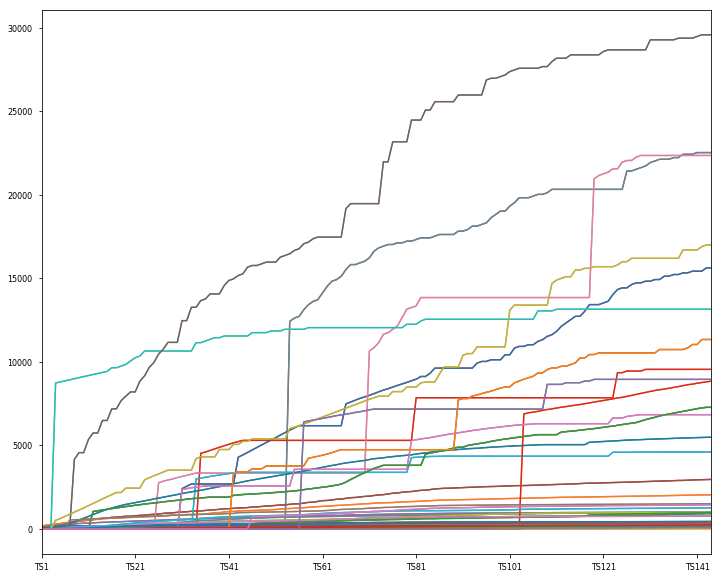

In [76]:
multiple_appearances.drop(['Platform','Topic','Platform_Topic'],axis=1).T.plot(legend=False,figsize=(12,10))

In [83]:
multiple_appearances[multiple_appearances.Platform == 'Facebook'].Topic.value_counts()

Palestine    11
Economy       8
Microsoft     6
Obama         4
Name: Topic, dtype: int64

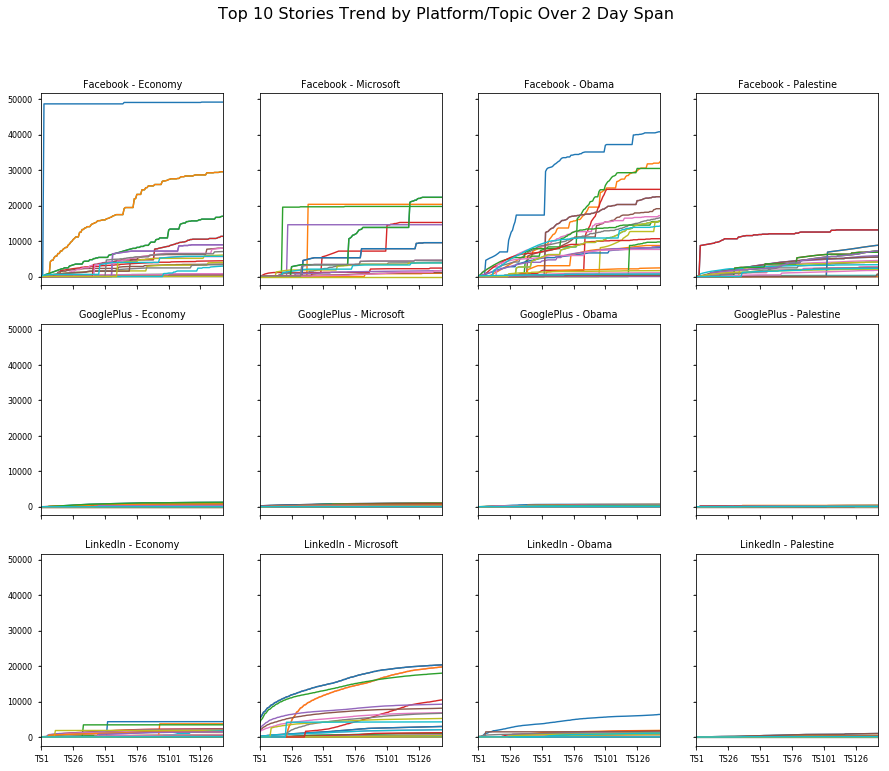

In [116]:
fig, charts = plt.subplots(nrows=3,ncols=4,figsize=(15,12),sharex=True,sharey=True)

for platform_topic, chart in zip(url_find,charts.flatten()):
    df = top_articles.drop(['Platform','Topic'],axis=1)
    platform, topic = platform_topic.split('_')
    df = df[df['Platform_Topic'] == platform_topic]
    df.drop('Platform_Topic',axis=1,inplace=True)
    df.T.plot(ax=chart,legend=False)
    chart.set_title('{} - {}'.format(platform,topic))

plt.suptitle('Top 10 Stories Trend by Platform/Topic Over 2 Day Span',fontsize=16)
plt.figure(figsize=(12,10))
plt.show()

## Observations thus far: ##

    - Facebook appears to have been the preferred platform for sharing new stories
    - GooglePlus was a near non-factor in news popularity metrics
    - LinkedIn cares a lot about Microsoft